### Single-objective and Multi-objective Bayesian optimization for a retention modelling toy example

In this tutorial, we illustrate how to implement the single-objective and multi-objective BO algorithms. It closely follows the toy retention modelling experiment shown in Section 4.5 of [Closed-loop automatic gradient design for liquid chromatography using Bayesian optimization](https://chemrxiv.org/engage/chemrxiv/article-details/62e2a383e7fc8f9e388caabc).

In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt

import torch

from botorch.sampling.samplers import SobolQMCNormalSampler

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel, SpectralMixtureKernel, PolynomialKernel, LinearKernel
from gpytorch.priors import GammaPrior

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from botorch.utils.transforms import normalize, unnormalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, NoisyExpectedImprovement, qNoisyExpectedImprovement

from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement

from bo_code.MaternSortKernel import MaternSortKernel
from bo_code.BO import BO_round, MOBO_round

from rm_code.crf import crf, capped_sum_of_resolutions, sort_peaks
from rm_code.retention_model import retention_time_multisegment_gradient, compute_chromatogram
import rm_code.read_data as rd
import rm_code.chromatographic_response_functions as of
from rm_code.plot_chromatogram import plot_chromatogram

from utils.utils import seed_everything, generate_initial_sorted_data, bo_to_rm, best_so_far, hv, ci

/Users/jimboelrijk/opt/anaconda3/envs/matlab_compat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load some retention parameters (for Linear Solvent Strength model)
ret_pars = np.loadtxt('data/RetentionParams_Section4.5.txt') # retention parameters from example in Section 4.5

k0_list = np.exp(ret_pars[:,0])
S_list = ret_pars[:,1]

In [3]:
# Set some default parameters
t_0 = 0.8 # dead time 
t_D = 0.8 # dwell time
N = 1000 # plate number
t_init = 0 # init time

In [4]:
# Let's try out a linear gradient
phi_list_lin = [0, 0.5, 1] # phi values
t_list_lin = [0, 30, 60] # time values
# compute retention times and peak widths
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_lin, t_list_lin, N)

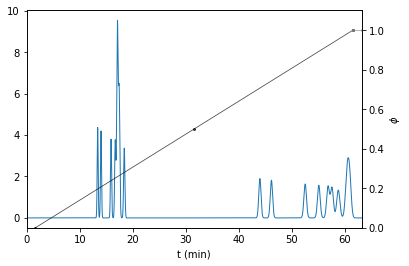

In [5]:
# plot chromatogram
plot_chromatogram(tR_list, W_list, phi_list_lin, t_list_lin, t_D, t_0, t_init)

In [6]:
# compute score of measurement (eq 6. in paper)
score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
# compute time score, i.e. time of last eluting peak.
time_score_lin = np.max(tR_list)
print(score_lin, time_score_lin)

12.098972668422277 61.0081858678997


# Let's try and find a handpicked gradient program, this will serve as a nice baseline for the Bayesian optimization algorithm

In [7]:
phi_list_ms = [0,0.18, 0.25,0.8, 1, 1]
t_list_ms = [0,0.1, 13,13.1, 30,60]
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_ms, t_list_ms, N)

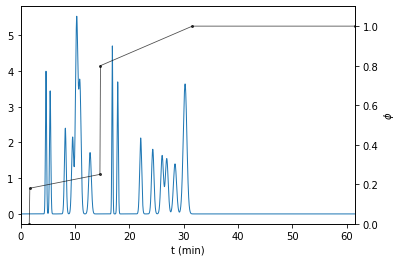

In [8]:
plot_chromatogram(tR_list, W_list, phi_list_ms, t_list_ms, t_D, t_0, t_init)

In [9]:
# compute scores 
score_ms = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
# compute time score, i.e. time of last eluting peak.
time_score_ms = np.max(tR_list)
print(score_ms, time_score_ms)

12.730314412317586 30.402499679605615


### Using the retention model, and score functions demonstrated above, we will now implement a Bayesian Optimization loop for the single-objective case.

Trial  0
INITIAL MEASUREMENT  0  RES SCORE  8.096540311807626 TIME SCORE 66.63039470412889 TOT SCORE 8.095874007860585


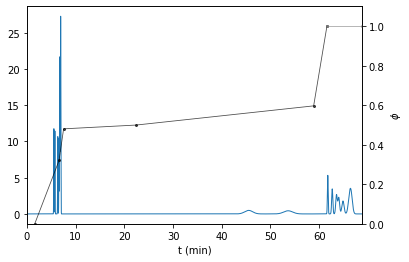

INITIAL MEASUREMENT  1  RES SCORE  12.244447653367132 TIME SCORE 60.52055116590354 TOT SCORE 12.243842447855473


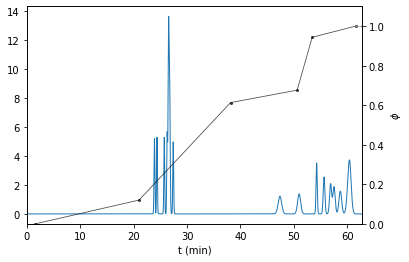

INITIAL MEASUREMENT  2  RES SCORE  12.261520725284369 TIME SCORE 56.357741284874045 TOT SCORE 12.260957147871519


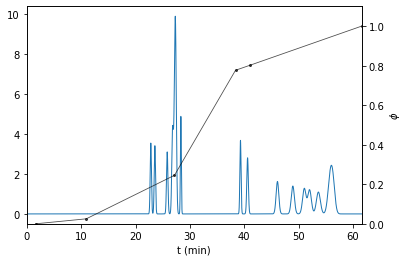

INITIAL MEASUREMENT  3  RES SCORE  8.841344664401719 TIME SCORE 64.31923442772293 TOT SCORE 8.840701472057441


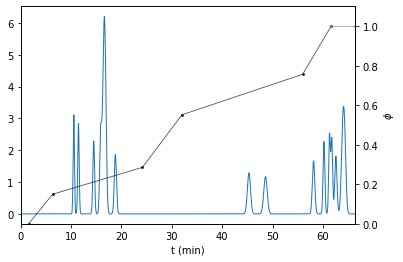

INITIAL MEASUREMENT  4  RES SCORE  12.532866437992698 TIME SCORE 36.393058196139776 TOT SCORE 12.532502507410737


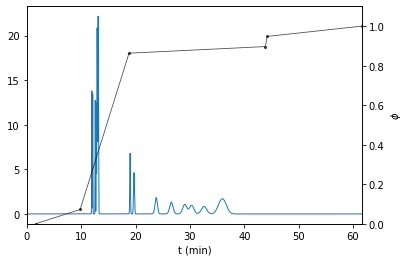

INITIAL MEASUREMENT  5  RES SCORE  10.338325756113619 TIME SCORE 63.447147176481096 TOT SCORE 10.337691284641854


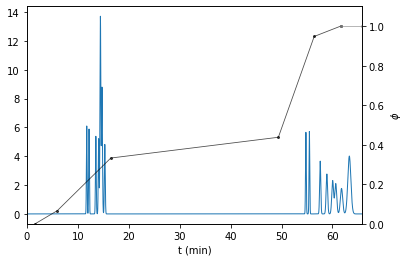

INITIAL MEASUREMENT  6  RES SCORE  12.672044432760591 TIME SCORE 54.92420637974644 TOT SCORE 12.671495190696794


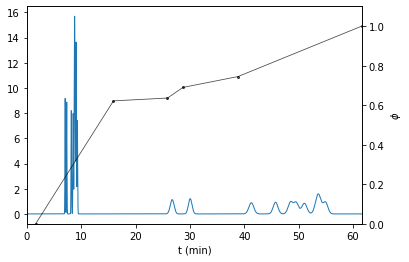

INITIAL MEASUREMENT  7  RES SCORE  5.557399428508089 TIME SCORE 69.32178955521617 TOT SCORE 5.5567062106125364


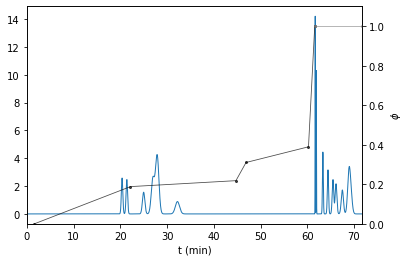

INITIAL MEASUREMENT  8  RES SCORE  12.722960236557503 TIME SCORE 53.21481517994945 TOT SCORE 12.722428088405703


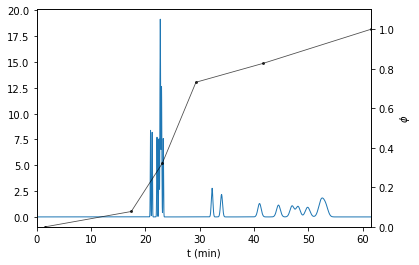

INITIAL MEASUREMENT  9  RES SCORE  10.119821344453445 TIME SCORE 63.66499675277798 TOT SCORE 10.119184694485918


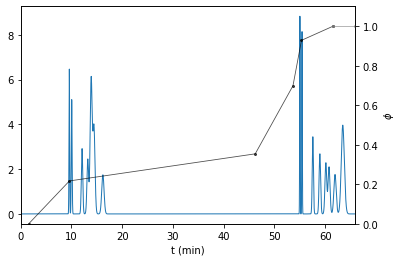

/Users/jimboelrijk/opt/anaconda3/envs/matlab_compat/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


MEASUREMENT SO  0  RES SCORE  12.396792820694785 TIME SCORE 49.198578411944766 TOT SCORE 12.396792820694785


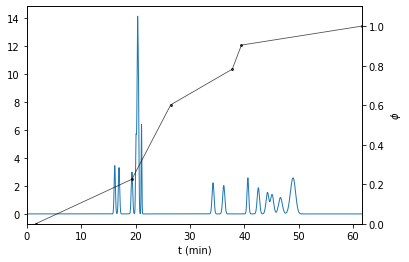

MEASUREMENT SO  1  RES SCORE  8.964367262967201 TIME SCORE 50.01156318743849 TOT SCORE 8.964367262967201


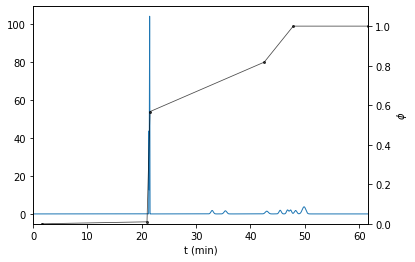

MEASUREMENT SO  2  RES SCORE  12.79068198620876 TIME SCORE 53.07797941487321 TOT SCORE 12.79068198620876


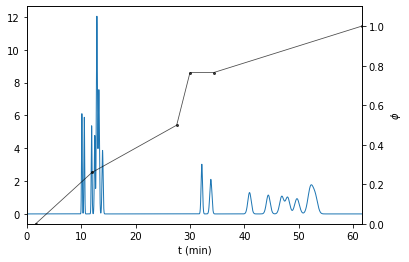

MEASUREMENT SO  3  RES SCORE  12.778301850453257 TIME SCORE 50.29456667040267 TOT SCORE 12.778301850453257


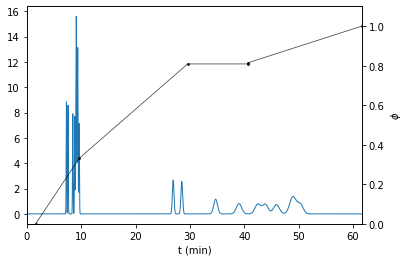

MEASUREMENT SO  4  RES SCORE  12.551188488711833 TIME SCORE 54.8490900199854 TOT SCORE 12.551188488711833


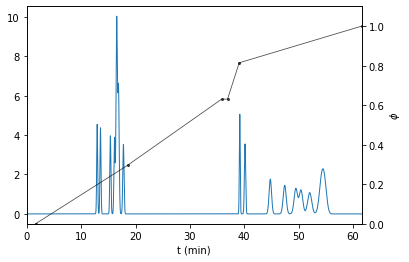

MEASUREMENT SO  5  RES SCORE  12.749694188736099 TIME SCORE 47.95130966326785 TOT SCORE 12.749694188736099


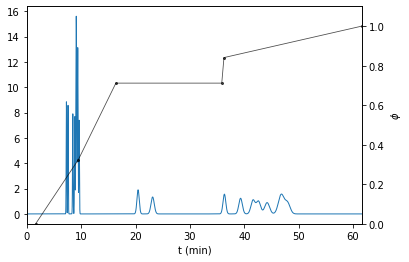

MEASUREMENT SO  6  RES SCORE  12.709571115409897 TIME SCORE 55.13094117393315 TOT SCORE 12.709571115409897


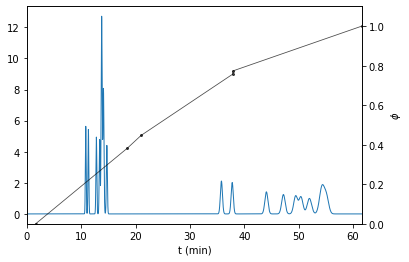

MEASUREMENT SO  7  RES SCORE  12.591613722946825 TIME SCORE 51.68471475583016 TOT SCORE 12.591613722946825


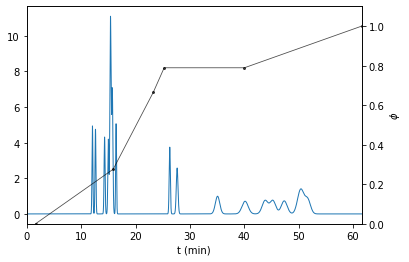

MEASUREMENT SO  8  RES SCORE  12.794799025658115 TIME SCORE 48.916226662843115 TOT SCORE 12.794799025658115


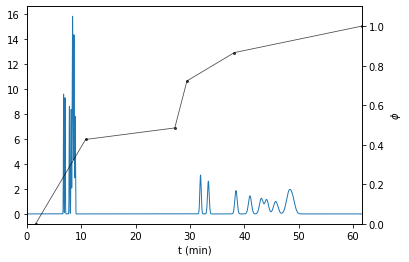

MEASUREMENT SO  9  RES SCORE  12.517387248581665 TIME SCORE 50.691167589905994 TOT SCORE 12.517387248581665


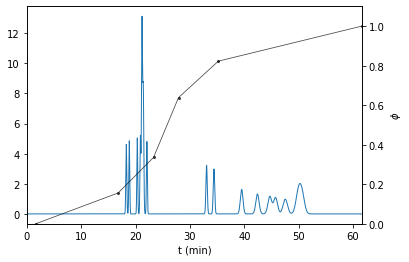

MEASUREMENT SO  10  RES SCORE  12.81468840739284 TIME SCORE 44.64430774101834 TOT SCORE 12.81468840739284


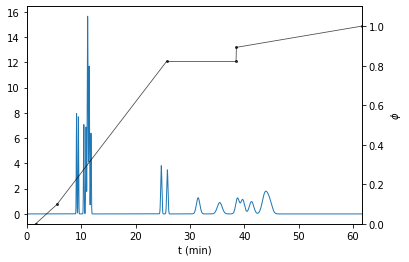

MEASUREMENT SO  11  RES SCORE  12.798939516583333 TIME SCORE 48.58881402332164 TOT SCORE 12.798939516583333


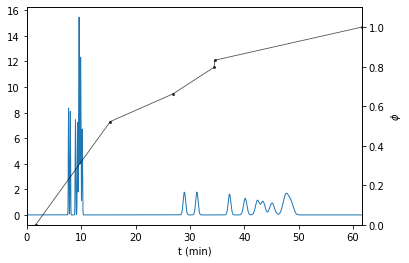

MEASUREMENT SO  12  RES SCORE  12.69307630561036 TIME SCORE 52.857810802809894 TOT SCORE 12.69307630561036


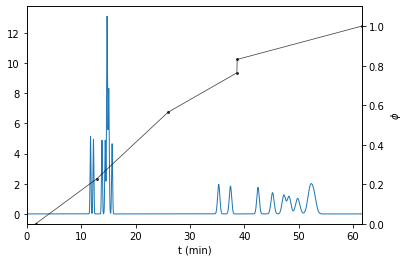

MEASUREMENT SO  13  RES SCORE  12.46418273515014 TIME SCORE 30.202674112301835 TOT SCORE 12.46418273515014


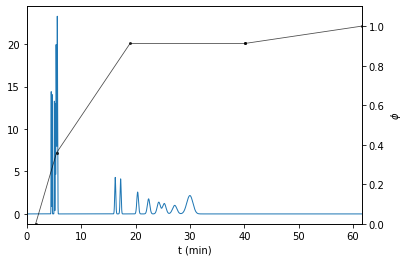

MEASUREMENT SO  14  RES SCORE  12.518272520544144 TIME SCORE 56.13683104284178 TOT SCORE 12.518272520544144


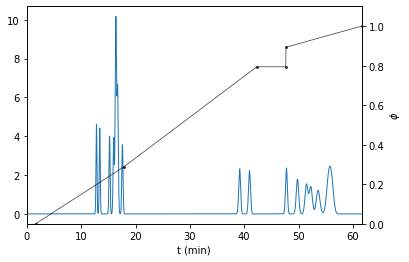

MEASUREMENT SO  15  RES SCORE  12.492728353578578 TIME SCORE 50.72952446971782 TOT SCORE 12.492728353578578


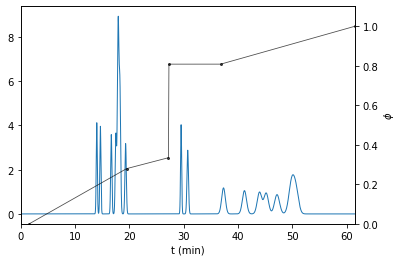

MEASUREMENT SO  16  RES SCORE  12.749953301665764 TIME SCORE 50.86382193924354 TOT SCORE 12.749953301665764


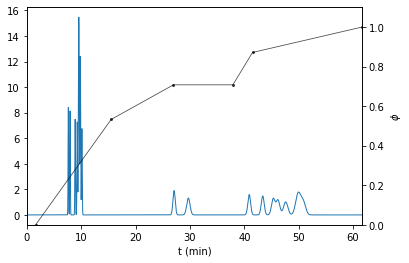

MEASUREMENT SO  17  RES SCORE  12.831117418825452 TIME SCORE 50.34551793802916 TOT SCORE 12.831117418825452


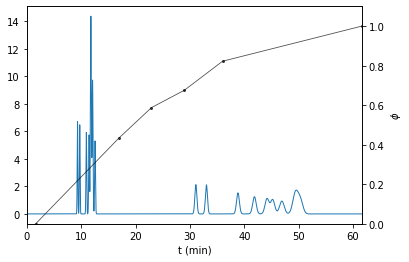

MEASUREMENT SO  18  RES SCORE  12.660218112458107 TIME SCORE 42.9247194373897 TOT SCORE 12.660218112458107


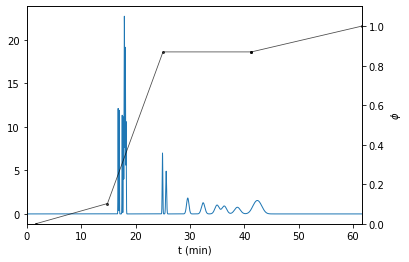

MEASUREMENT SO  19  RES SCORE  12.688508731371401 TIME SCORE 53.662295098362534 TOT SCORE 12.688508731371401


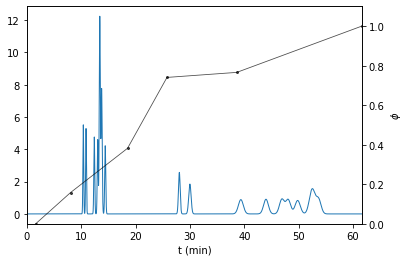

MEASUREMENT SO  20  RES SCORE  12.26219480850796 TIME SCORE 46.98615760190385 TOT SCORE 12.26219480850796


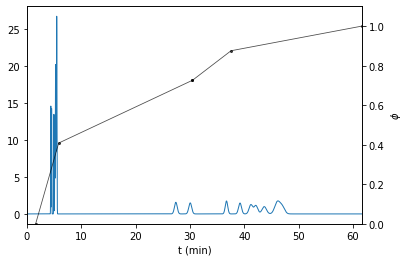

MEASUREMENT SO  21  RES SCORE  12.917666456343463 TIME SCORE 40.91349423867854 TOT SCORE 12.917666456343463


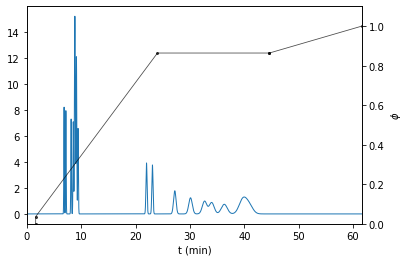

MEASUREMENT SO  22  RES SCORE  12.519516825776723 TIME SCORE 59.802392705180765 TOT SCORE 12.519516825776723


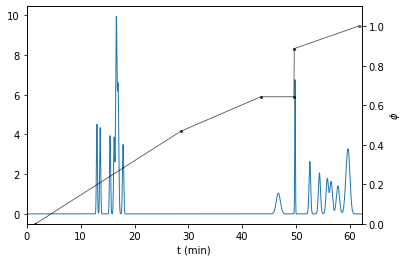

MEASUREMENT SO  23  RES SCORE  12.668695723609062 TIME SCORE 53.77683997934764 TOT SCORE 12.668695723609062


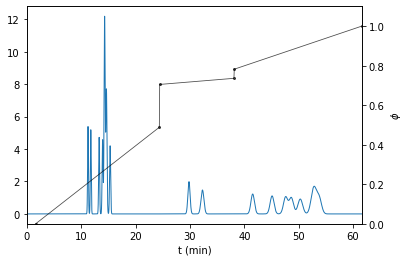

MEASUREMENT SO  24  RES SCORE  12.716170301255447 TIME SCORE 36.10430509910724 TOT SCORE 12.716170301255447


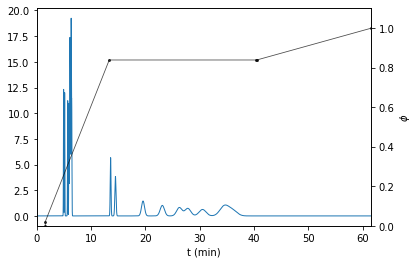

Trial  1
INITIAL MEASUREMENT  0  RES SCORE  7.9930453635131355 TIME SCORE 65.8271530951557 TOT SCORE 7.9923870919821836


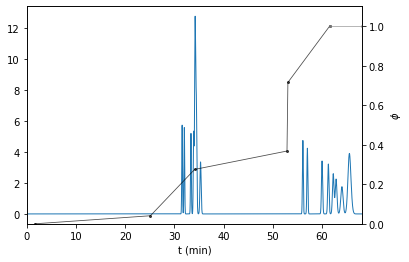

INITIAL MEASUREMENT  1  RES SCORE  12.228378136339764 TIME SCORE 61.69001686645061 TOT SCORE 12.2277612361711


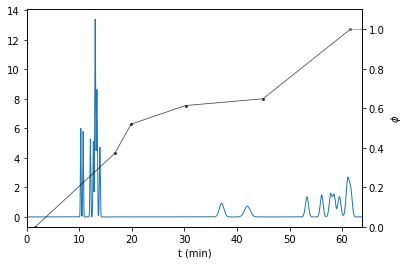

INITIAL MEASUREMENT  2  RES SCORE  12.511915085889926 TIME SCORE 51.465572551892826 TOT SCORE 12.511400430164407


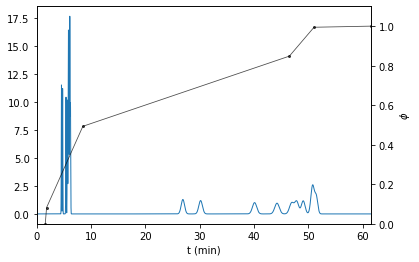

INITIAL MEASUREMENT  3  RES SCORE  12.6431335160712 TIME SCORE 54.654678599864994 TOT SCORE 12.642586969285201


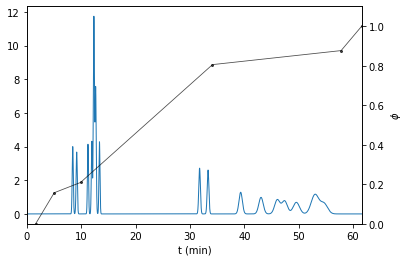

INITIAL MEASUREMENT  4  RES SCORE  12.553910505794795 TIME SCORE 56.49093441244006 TOT SCORE 12.55334559645067


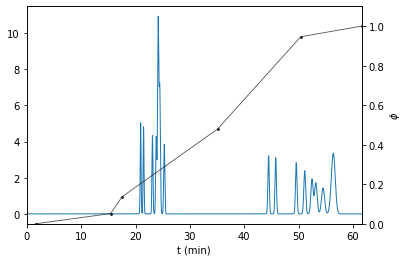

INITIAL MEASUREMENT  5  RES SCORE  12.400142088341312 TIME SCORE 43.43348487603141 TOT SCORE 12.399707753492551


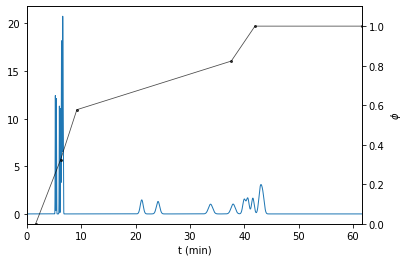

INITIAL MEASUREMENT  6  RES SCORE  5.509539121761731 TIME SCORE 68.98008247720637 TOT SCORE 5.5088493209369584


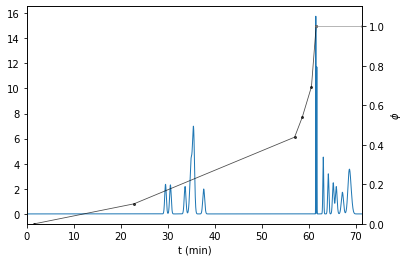

INITIAL MEASUREMENT  7  RES SCORE  12.579378017966864 TIME SCORE 44.22810779393912 TOT SCORE 12.578935736888925


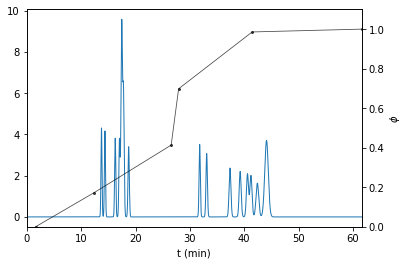

INITIAL MEASUREMENT  8  RES SCORE  11.250330724613498 TIME SCORE 62.34814311764703 TOT SCORE 11.249707243182321


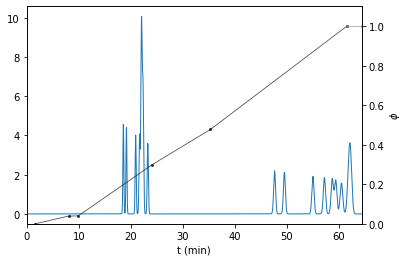

INITIAL MEASUREMENT  9  RES SCORE  11.135531898227292 TIME SCORE 41.56296564216419 TOT SCORE 11.13511626857087


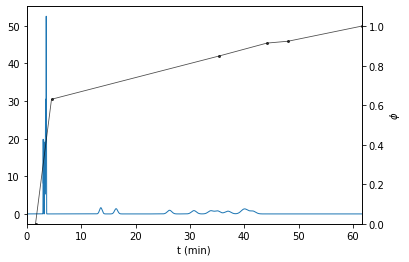

MEASUREMENT SO  0  RES SCORE  11.28919583138674 TIME SCORE 51.536658106179644 TOT SCORE 11.28919583138674


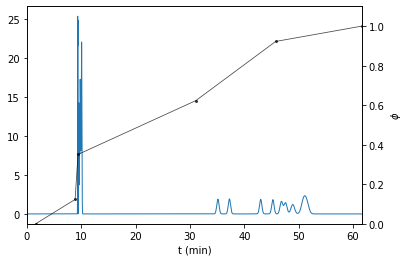

MEASUREMENT SO  1  RES SCORE  12.926718698287418 TIME SCORE 45.57225996737017 TOT SCORE 12.926718698287418


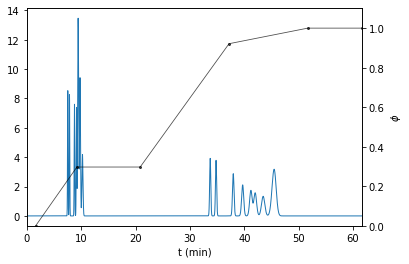

MEASUREMENT SO  2  RES SCORE  12.302369654034816 TIME SCORE 49.63077236770282 TOT SCORE 12.302369654034816


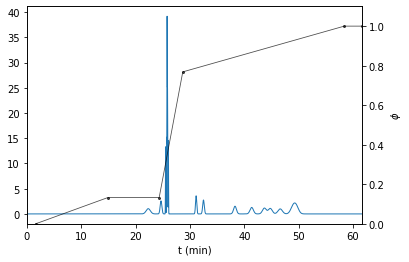

MEASUREMENT SO  3  RES SCORE  12.558294754084375 TIME SCORE 44.508608711833034 TOT SCORE 12.558294754084375


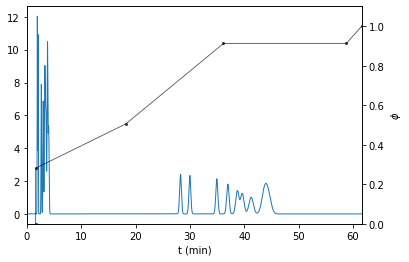

MEASUREMENT SO  4  RES SCORE  12.79904013367034 TIME SCORE 53.61860529335944 TOT SCORE 12.79904013367034


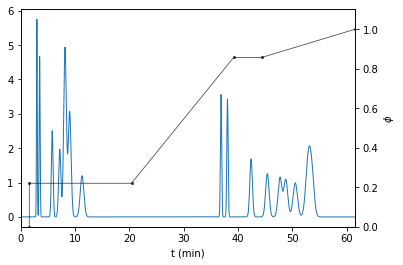

MEASUREMENT SO  5  RES SCORE  12.835351879862673 TIME SCORE 56.72145696948463 TOT SCORE 12.835351879862673


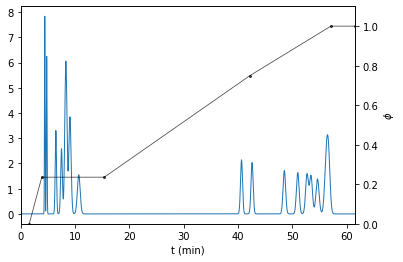

MEASUREMENT SO  6  RES SCORE  12.977060931784576 TIME SCORE 44.18340270490781 TOT SCORE 12.977060931784576


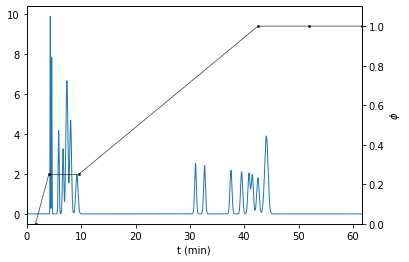

MEASUREMENT SO  7  RES SCORE  12.855050932075063 TIME SCORE 55.62983809711059 TOT SCORE 12.855050932075063


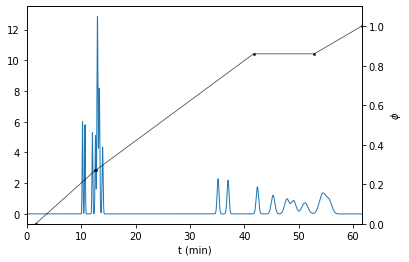

MEASUREMENT SO  8  RES SCORE  12.831023395846776 TIME SCORE 48.20511433679774 TOT SCORE 12.831023395846776


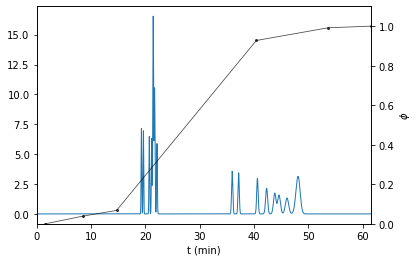

MEASUREMENT SO  9  RES SCORE  12.9438876861155 TIME SCORE 41.41981642019363 TOT SCORE 12.9438876861155


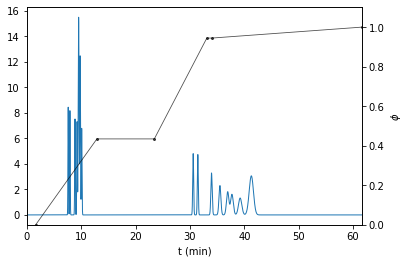

MEASUREMENT SO  10  RES SCORE  12.869402752225168 TIME SCORE 41.891130670812466 TOT SCORE 12.869402752225168


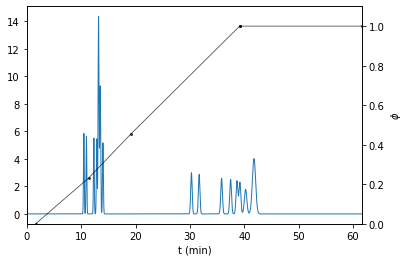

MEASUREMENT SO  11  RES SCORE  9.572243345418588 TIME SCORE 41.77800997224638 TOT SCORE 9.572243345418588


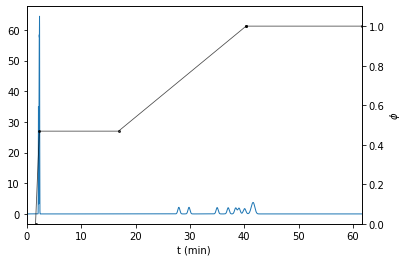

MEASUREMENT SO  12  RES SCORE  12.862966785177004 TIME SCORE 42.104188502022225 TOT SCORE 12.862966785177004


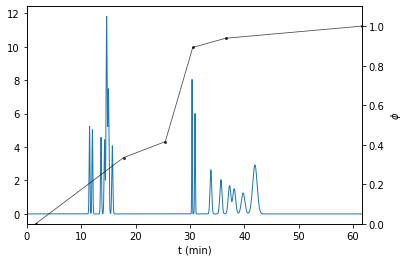

MEASUREMENT SO  13  RES SCORE  12.753250007514977 TIME SCORE 45.065309339768355 TOT SCORE 12.753250007514977


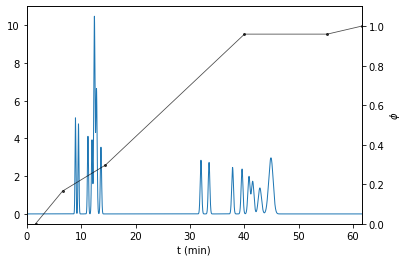

MEASUREMENT SO  14  RES SCORE  12.90364166825209 TIME SCORE 47.65451332801697 TOT SCORE 12.90364166825209


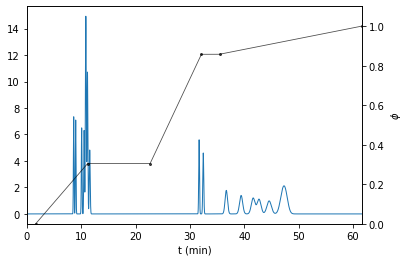

MEASUREMENT SO  15  RES SCORE  12.863774159850122 TIME SCORE 42.19528387662903 TOT SCORE 12.863774159850122


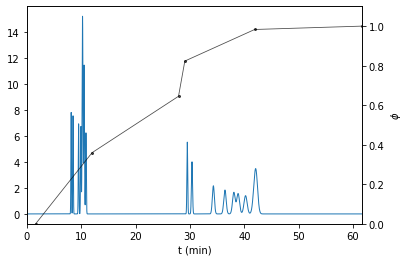

MEASUREMENT SO  16  RES SCORE  12.609268324455638 TIME SCORE 55.684958372405966 TOT SCORE 12.609268324455638


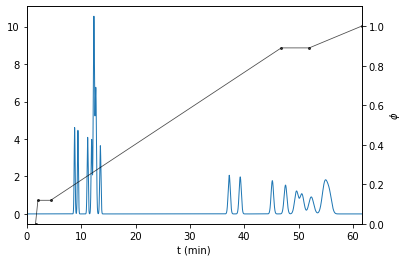

MEASUREMENT SO  17  RES SCORE  13.080025331523162 TIME SCORE 43.844284579874696 TOT SCORE 13.080025331523162


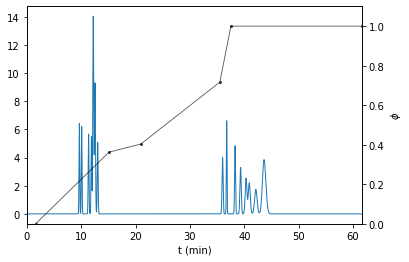

MEASUREMENT SO  18  RES SCORE  12.914898082949144 TIME SCORE 38.274031284395726 TOT SCORE 12.914898082949144


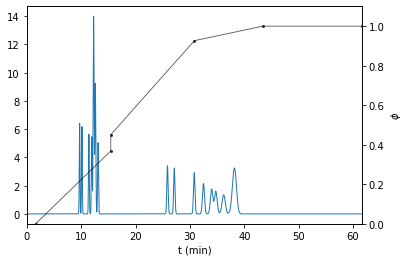

MEASUREMENT SO  19  RES SCORE  13.203504129637148 TIME SCORE 34.297489313200806 TOT SCORE 13.203504129637148


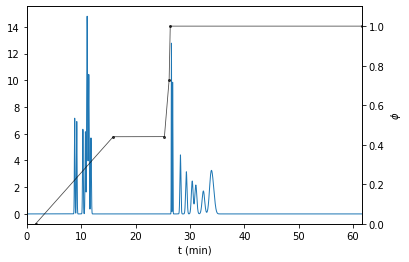

MEASUREMENT SO  20  RES SCORE  13.094787922813898 TIME SCORE 36.91605373149784 TOT SCORE 13.094787922813898


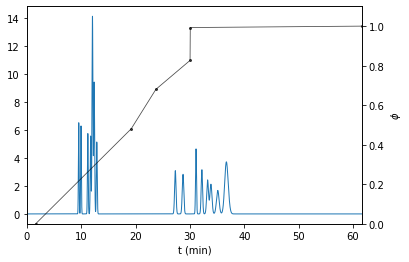

MEASUREMENT SO  21  RES SCORE  12.881914474138943 TIME SCORE 42.157891942822005 TOT SCORE 12.881914474138943


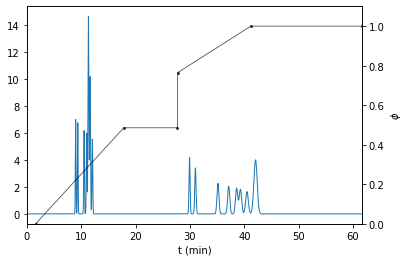

MEASUREMENT SO  22  RES SCORE  13.149371782331668 TIME SCORE 35.83357806040861 TOT SCORE 13.149371782331668


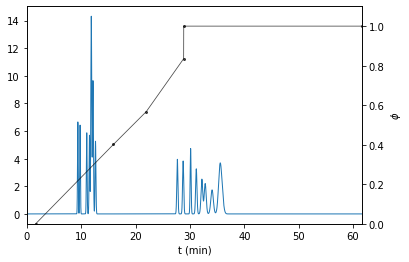

MEASUREMENT SO  23  RES SCORE  12.69119220791841 TIME SCORE 57.20643403016371 TOT SCORE 12.69119220791841


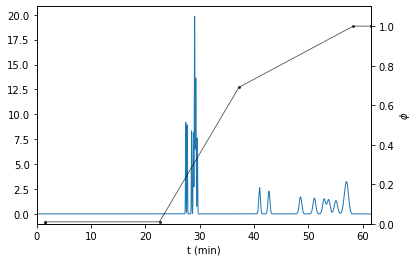

MEASUREMENT SO  24  RES SCORE  12.921866076563939 TIME SCORE 43.42193947593215 TOT SCORE 12.921866076563939


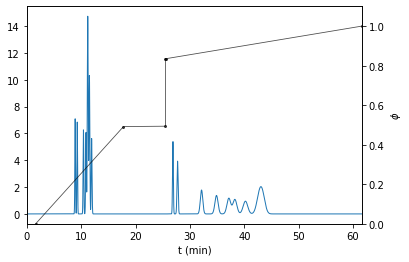

In [10]:
# Let's now set up a Bayesian optimization loop for the single-objective case.

# Set some fixed parameters
fixed_phi_pars = [[0.], [1.]] # fixed phi points
fixed_time_pars = [[0.], [60.]] # at fixed time points

# We will optimize 8 parameters (4 gradient nodes) for which we set bounds.
# phi points between 0.01 and 1 modifier fraction and tim between 0.01 and 59.9 minutes
# lower and upper bounds of parameters phi1, phi2, phi3, phi4, t1, t2, t3, t4
bounds = torch.stack([torch.tensor([0.01, 0.01, 0.01, 0.01,  0.01, 0.01, 0.01, 0.01]),
                      torch.tensor([1, 1, 1, 1., 59.9, 59.9, 59.9, 59.9])])

# bounds after normalization to [0,1]
norm_bounds = torch.stack([torch.zeros(8), torch.ones(8)])

# number of random initial experiments
init_measurements = 10

# optimization budget
iterations = 25

# number of trials
trials = 2

# prefacs to scalarize multiple objectives into a single scalar value
prefacs = [1, 1e-5] # this means there is a heavy focus on resolution

# create some lists to store results in
scores_so_all = []
seperate_scores_so_all = []
pars_so_all = []

# Loop over trials
for trial in range(trials):
    print('Trial ', trial)
    
    # Set random seed for reproducibility
    seed_everything(trial)
    
    # create lists to fill with results per trial
    scores_so = []
    seperate_scores_so = []
    pars_so = []
    
    # generate initial experiments
    pars = generate_initial_sorted_data(bounds, n=init_measurements)
    pars_so = pars
    # convert to parameters that retention modeling code can handle
    phi_list, t_list = bo_to_rm(pars, fixed_phi_pars, fixed_time_pars)
    
    # Perform random initial experiments
    for i in range(len(phi_list)):
        tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[i], t_list[i], N)
        score = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore = -np.max(tR_list)

        score_so = (score*prefacs[0]) + (maxtimescore * prefacs[1])
        score_seperate_so = [score, maxtimescore]

        print('INITIAL MEASUREMENT ', i, ' RES SCORE ', score, 'TIME SCORE', -maxtimescore, 'TOT SCORE', score_so)
        plot_chromatogram(tR_list, W_list, phi_list[i], t_list[i], t_D, t_0, t_init)

        scores_so.append(score_so)
        seperate_scores_so.append(score_seperate_so)
    
    # Now we are ready to do BO loop
    for iteration in range(iterations):
        # perform BO round
        new_pars_so = BO_round(bounds, norm_bounds, np.array(scores_so), pars_so)

        phi_list_so, t_list_so = bo_to_rm(new_pars_so, fixed_phi_pars, fixed_time_pars)

        # perform experiments
        tR_list_so, W_list_so = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_so[0], 
                                                     t_list_so[0],N)
        # compute scores
        score_so = capped_sum_of_resolutions(tR_list_so, W_list_so, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore_so = -np.max(tR_list_so)

        print('MEASUREMENT SO ', iteration, ' RES SCORE ', score_so, 'TIME SCORE', -maxtimescore_so, 'TOT SCORE', score_so)
        plot_chromatogram(tR_list_so, W_list_so, phi_list_so[0], t_list_so[0], t_D, t_0, t_init)

        score_seperate_so = [score_so, maxtimescore_so]
        score_so = (score_so*prefacs[0]) +  (maxtimescore_so*prefacs[1])

        # update training data
        # update scores
        scores_so.append(score_so)
        seperate_scores_so.append(score_seperate_so)

        # update pars
        pars_so = np.concatenate((pars_so, new_pars_so), axis=0)
    
    # after each trial, append all values to list
    scores_so_all.append(scores_so)
    seperate_scores_so_all.append(seperate_scores_so)
    pars_so_all.append(pars_so)


### Let's visualize some results

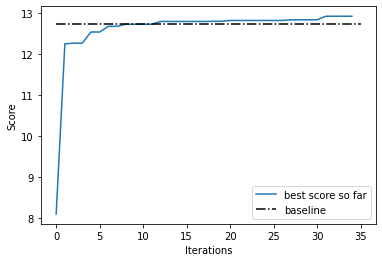

Measurement  31


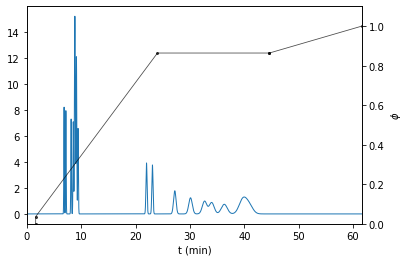

In [11]:
scores_best_so_far = best_so_far(np.array(scores_so_all))

trial_to_observe = 0
# plot best observed scores at each iteration
plt.plot(scores_best_so_far[trial_to_observe], label='best score so far')

# plot score of handpicked program
baseline = score_ms * prefacs[0] + time_score_ms * prefacs[1]
plt.hlines(baseline, 0, len(scores_so_all[trial_to_observe]), ls='-.', label='baseline', color='black')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.show()


# plot best measurement (according to score function)
idxloc = np.argmax(scores_so_all[trial_to_observe])
best_pars = np.reshape(np.array(pars_so_all)[trial_to_observe, idxloc], (1,-1))

phi_list, t_list = bo_to_rm(best_pars, fixed_phi_pars, fixed_time_pars)

# perform experiments
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[0], 
                                             t_list[0],N)
print('Measurement ', idxloc)
plot_chromatogram(tR_list, W_list, phi_list[0], t_list[0], t_D, t_0, t_init)


In [12]:
# When running multiple trials, uncomment for plot with error bars
# scores_best_so_far = best_so_far(np.array(scores_so_all))
# mean_scores = np.mean(scores_best_so_far, axis=0)
# cis = ci(scores_best_so_far, trials)

# plt.plot(np.arange(len(mean_scores)), mean_scores, label='best score so far')
# plt.fill_between(np.arange(len(mean_scores)), mean_scores - cis, mean_scores + cis, alpha=0.6)
# plt.xlabel('Iterations')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.show()

### In similar fashion, we can set up a multi-objective BO loop

Trial  0
INITIAL MEASUREMENT  0  RES SCORE  8.096540311807626 TIME SCORE 66.63039470412889


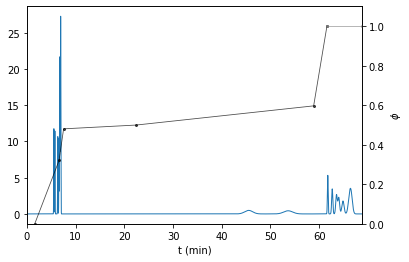

INITIAL MEASUREMENT  1  RES SCORE  12.244447653367132 TIME SCORE 60.52055116590354


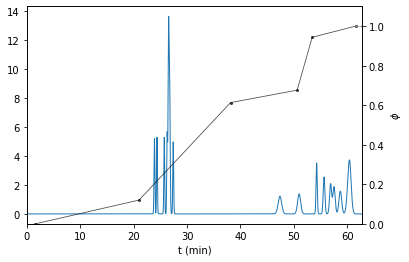

INITIAL MEASUREMENT  2  RES SCORE  12.261520725284369 TIME SCORE 56.357741284874045


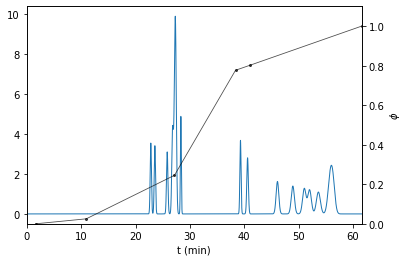

INITIAL MEASUREMENT  3  RES SCORE  8.841344664401719 TIME SCORE 64.31923442772293


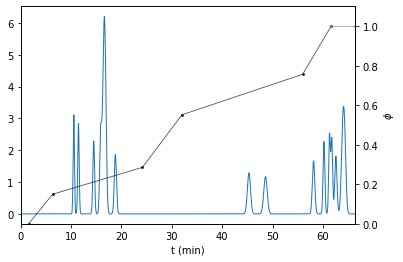

INITIAL MEASUREMENT  4  RES SCORE  12.532866437992698 TIME SCORE 36.393058196139776


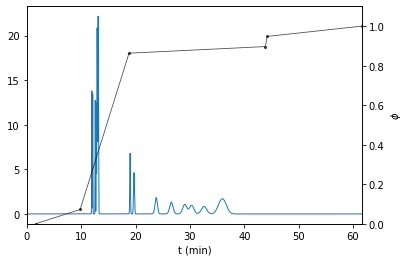

INITIAL MEASUREMENT  5  RES SCORE  10.338325756113619 TIME SCORE 63.447147176481096


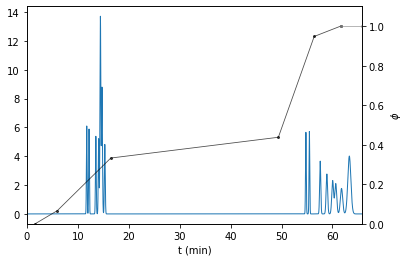

INITIAL MEASUREMENT  6  RES SCORE  12.672044432760591 TIME SCORE 54.92420637974644


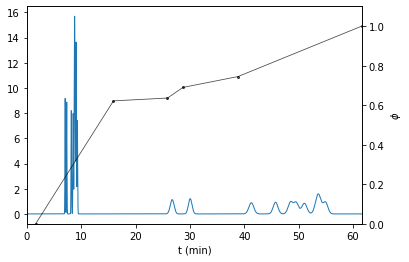

INITIAL MEASUREMENT  7  RES SCORE  5.557399428508089 TIME SCORE 69.32178955521617


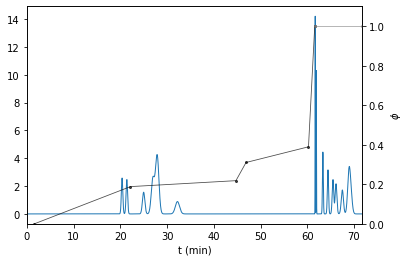

INITIAL MEASUREMENT  8  RES SCORE  12.722960236557503 TIME SCORE 53.21481517994945


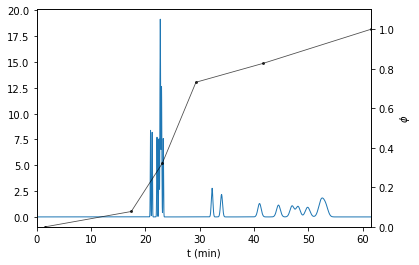

INITIAL MEASUREMENT  9  RES SCORE  10.119821344453445 TIME SCORE 63.66499675277798


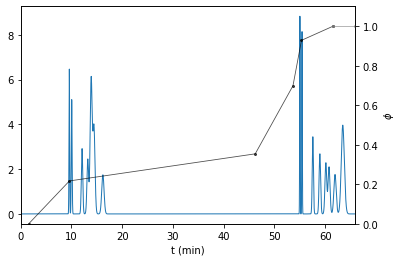

MEASUREMENT MO  0  RES SCORE  11.84439153009522 TIME SCORE 40.46049031880571


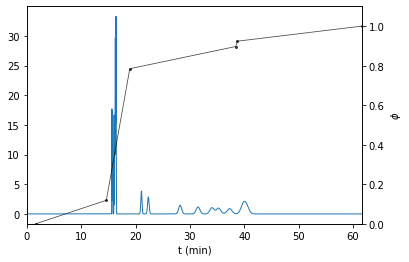

MEASUREMENT MO  1  RES SCORE  11.51160998422647 TIME SCORE 31.731962866168914


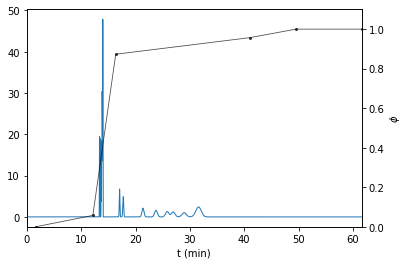

MEASUREMENT MO  2  RES SCORE  10.898421197955727 TIME SCORE 21.204788851854417


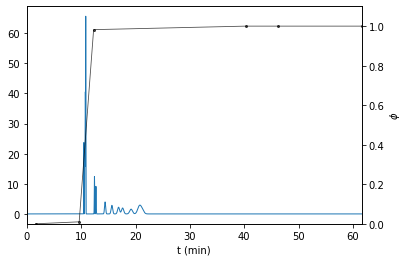

MEASUREMENT MO  3  RES SCORE  10.633476715516393 TIME SCORE 14.880452186566563


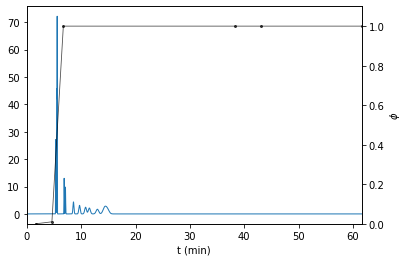

MEASUREMENT MO  4  RES SCORE  7.90474263713113 TIME SCORE 15.917885436709627


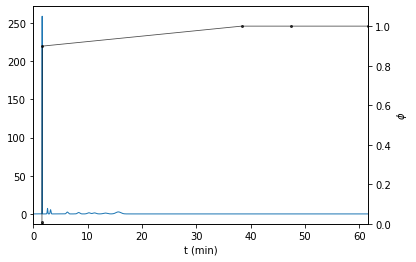

MEASUREMENT MO  5  RES SCORE  8.657990455205711 TIME SCORE 10.905949485675722


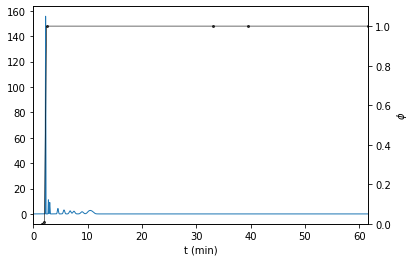

MEASUREMENT MO  6  RES SCORE  13.073063240332221 TIME SCORE 27.24078836719872


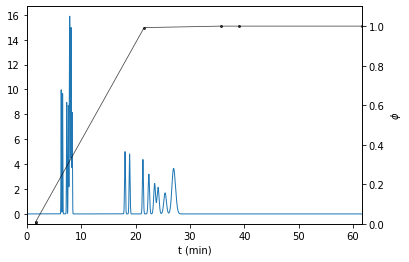

MEASUREMENT MO  7  RES SCORE  12.89846210960741 TIME SCORE 36.031587719458955


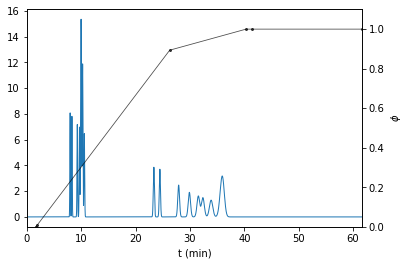

MEASUREMENT MO  8  RES SCORE  12.86973191650491 TIME SCORE 35.61241470730198


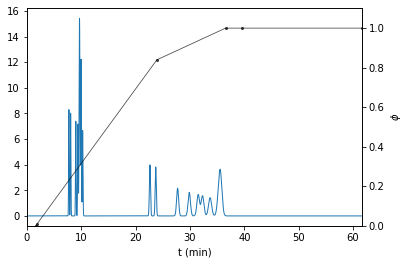

MEASUREMENT MO  9  RES SCORE  12.870624800626086 TIME SCORE 35.37706094228883


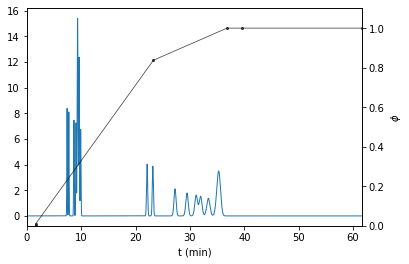

MEASUREMENT MO  10  RES SCORE  12.896210102833892 TIME SCORE 32.49513966381478


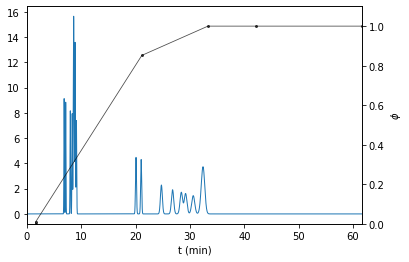

MEASUREMENT MO  11  RES SCORE  12.883031143745914 TIME SCORE 23.413283033329073


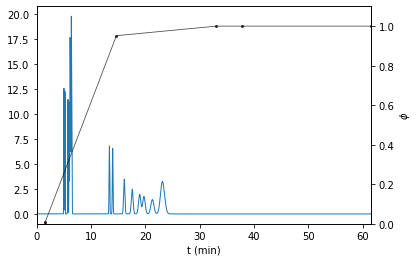

MEASUREMENT MO  12  RES SCORE  12.864940539159914 TIME SCORE 30.296666980237053


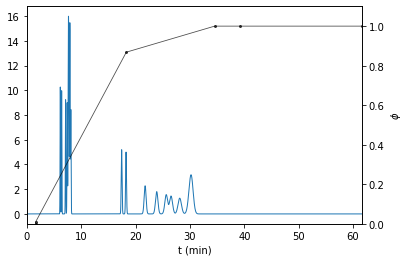

MEASUREMENT MO  13  RES SCORE  12.867244250999098 TIME SCORE 31.81481195571153


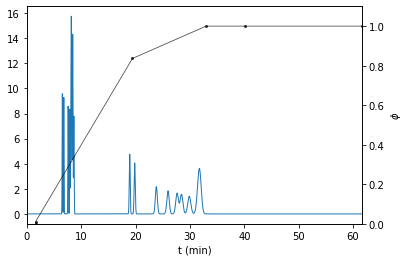

MEASUREMENT MO  14  RES SCORE  12.893497796138321 TIME SCORE 29.660749145137274


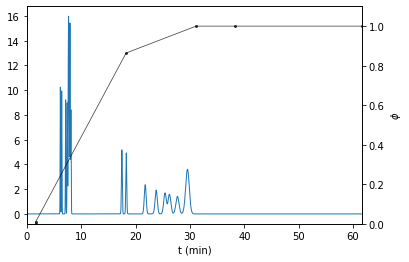

MEASUREMENT MO  15  RES SCORE  12.911569598877 TIME SCORE 31.003537238943007


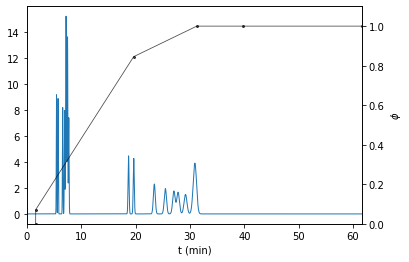

MEASUREMENT MO  16  RES SCORE  12.899263082923813 TIME SCORE 29.44602290514866


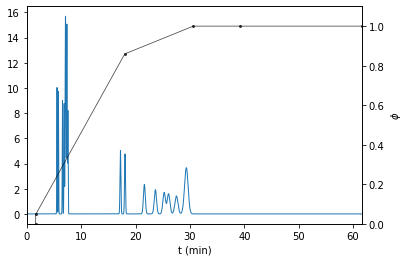

MEASUREMENT MO  17  RES SCORE  12.927910955232441 TIME SCORE 29.42746057788202


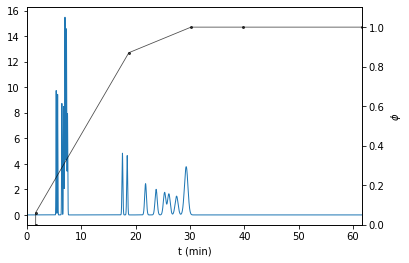

MEASUREMENT MO  18  RES SCORE  12.91102413122548 TIME SCORE 30.803448218823213


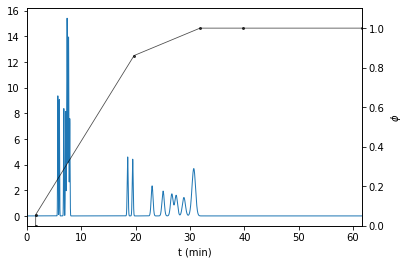

MEASUREMENT MO  19  RES SCORE  12.90684070748244 TIME SCORE 30.94646642023099


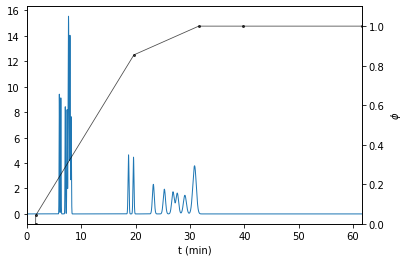

MEASUREMENT MO  20  RES SCORE  12.850021973764493 TIME SCORE 33.81803857143048


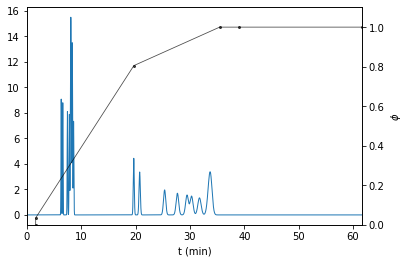

MEASUREMENT MO  21  RES SCORE  12.849487195809152 TIME SCORE 33.427082092405186


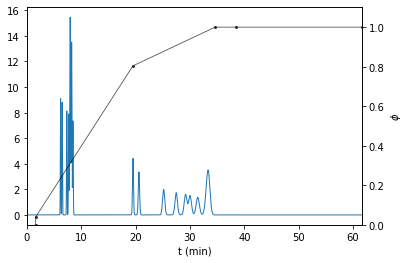

MEASUREMENT MO  22  RES SCORE  12.85373619770935 TIME SCORE 34.10223402316401


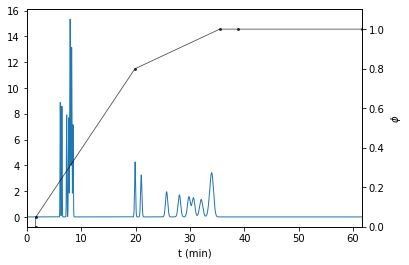

MEASUREMENT MO  23  RES SCORE  12.851181169838343 TIME SCORE 34.01936673455749


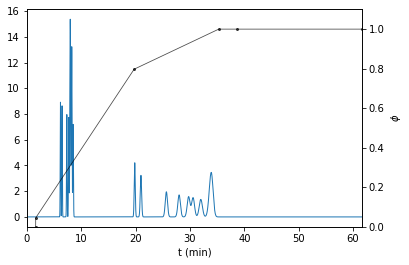

MEASUREMENT MO  24  RES SCORE  12.927173680427856 TIME SCORE 30.320667082828216


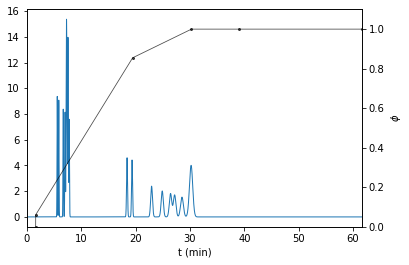

Trial  1
INITIAL MEASUREMENT  0  RES SCORE  7.9930453635131355 TIME SCORE 65.8271530951557


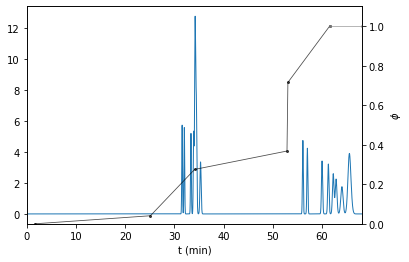

INITIAL MEASUREMENT  1  RES SCORE  12.228378136339764 TIME SCORE 61.69001686645061


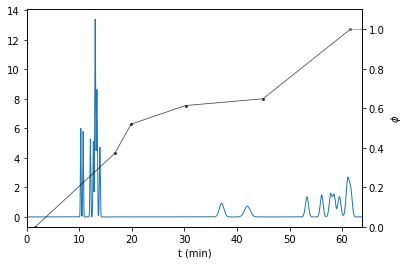

INITIAL MEASUREMENT  2  RES SCORE  12.511915085889926 TIME SCORE 51.465572551892826


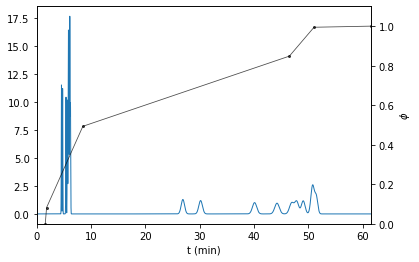

INITIAL MEASUREMENT  3  RES SCORE  12.6431335160712 TIME SCORE 54.654678599864994


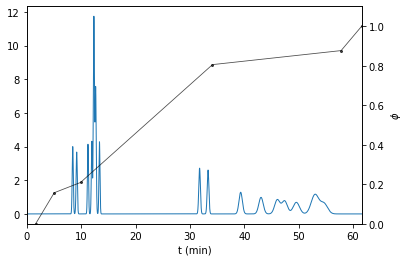

INITIAL MEASUREMENT  4  RES SCORE  12.553910505794795 TIME SCORE 56.49093441244006


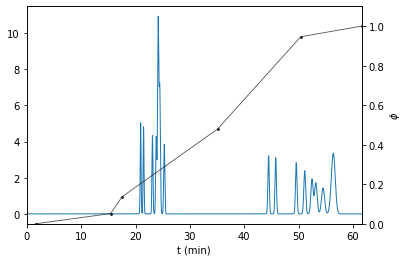

INITIAL MEASUREMENT  5  RES SCORE  12.400142088341312 TIME SCORE 43.43348487603141


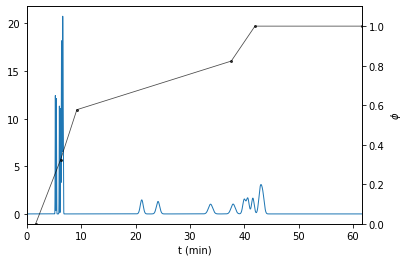

INITIAL MEASUREMENT  6  RES SCORE  5.509539121761731 TIME SCORE 68.98008247720637


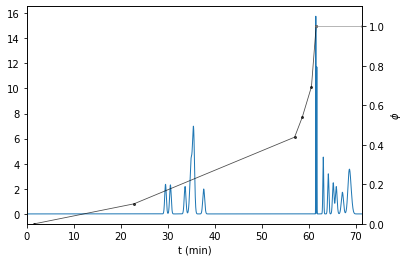

INITIAL MEASUREMENT  7  RES SCORE  12.579378017966864 TIME SCORE 44.22810779393912


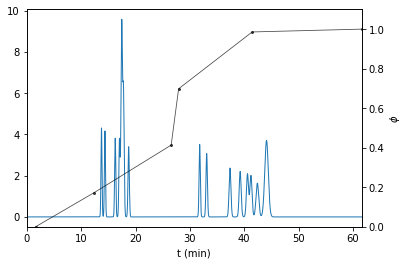

INITIAL MEASUREMENT  8  RES SCORE  11.250330724613498 TIME SCORE 62.34814311764703


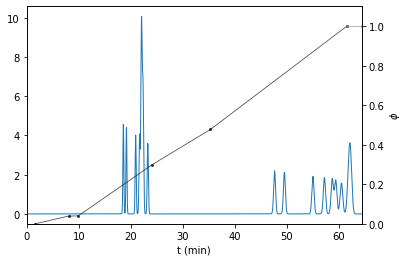

INITIAL MEASUREMENT  9  RES SCORE  11.135531898227292 TIME SCORE 41.56296564216419


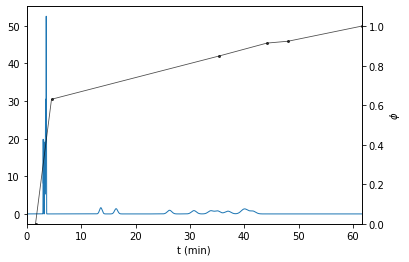

MEASUREMENT MO  0  RES SCORE  12.374569117457138 TIME SCORE 42.967208134522835


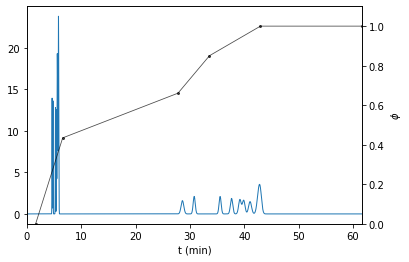

MEASUREMENT MO  1  RES SCORE  11.502512873232712 TIME SCORE 36.884944710385014


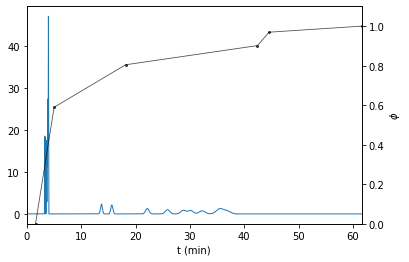

MEASUREMENT MO  2  RES SCORE  11.318904289142477 TIME SCORE 25.944034145419344


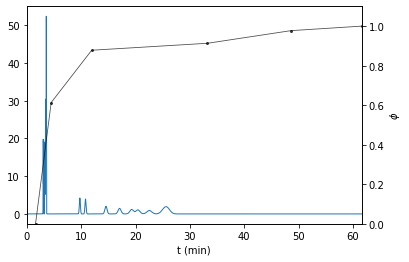

MEASUREMENT MO  3  RES SCORE  10.344907206353794 TIME SCORE 17.227953164234457


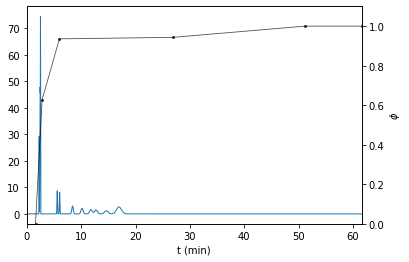

MEASUREMENT MO  4  RES SCORE  7.9245558203407676 TIME SCORE 10.521919998103401


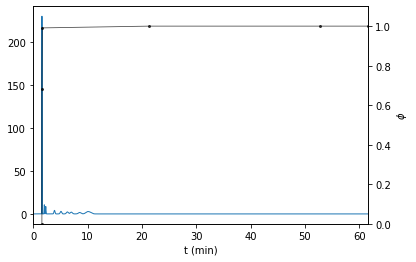

MEASUREMENT MO  5  RES SCORE  7.916510271225845 TIME SCORE 10.141451288206824


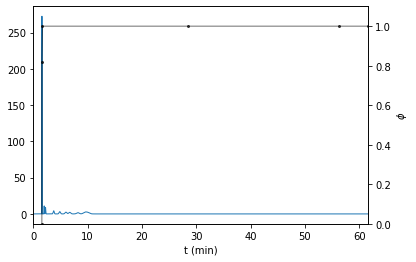

MEASUREMENT MO  6  RES SCORE  7.9133960101639405 TIME SCORE 10.114001466963813


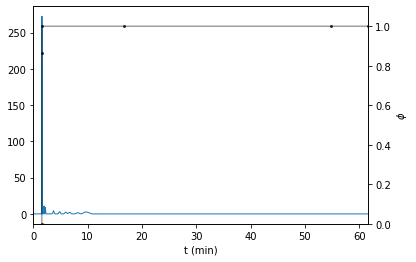

MEASUREMENT MO  7  RES SCORE  12.343759222905051 TIME SCORE 39.980898059848535


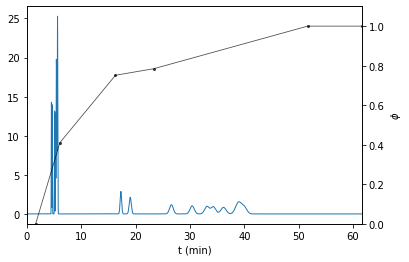

MEASUREMENT MO  8  RES SCORE  7.7398659858632435 TIME SCORE 16.221557984215462


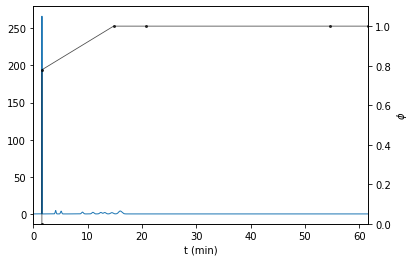

MEASUREMENT MO  9  RES SCORE  9.534038246689898 TIME SCORE 20.86294271086765


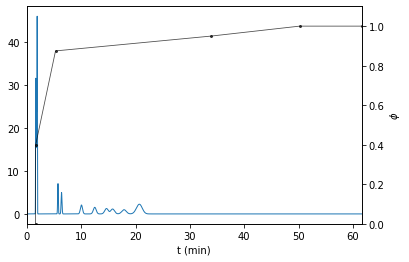

MEASUREMENT MO  10  RES SCORE  7.605821921251794 TIME SCORE 19.742448671367097


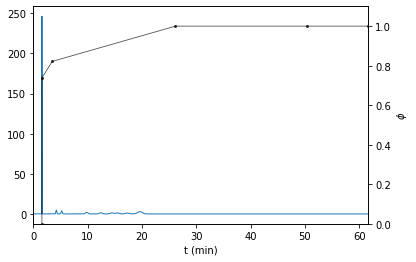

MEASUREMENT MO  11  RES SCORE  7.708221757902548 TIME SCORE 17.46314377630025


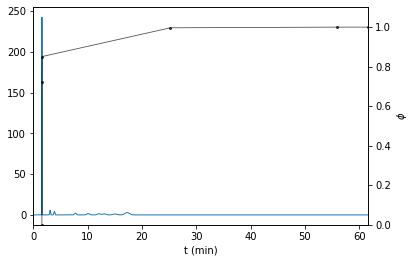

MEASUREMENT MO  12  RES SCORE  7.708316076954788 TIME SCORE 17.383050063963957


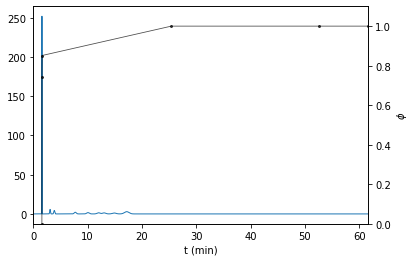

MEASUREMENT MO  13  RES SCORE  7.71885614001794 TIME SCORE 17.117114448811577


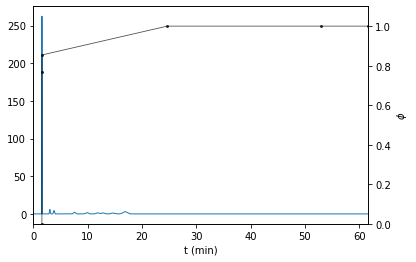

MEASUREMENT MO  14  RES SCORE  7.7428071145668 TIME SCORE 16.654220674788352


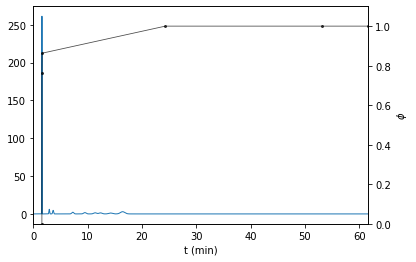

MEASUREMENT MO  15  RES SCORE  7.732742037665377 TIME SCORE 16.865976864997094


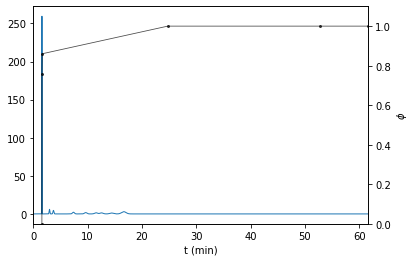

MEASUREMENT MO  16  RES SCORE  7.736240309643708 TIME SCORE 16.801281856486497


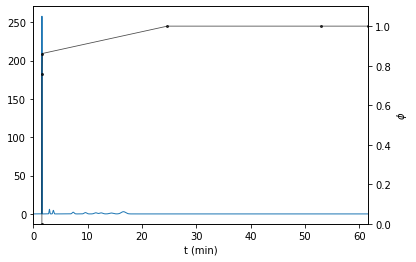

MEASUREMENT MO  17  RES SCORE  11.117356630744638 TIME SCORE 24.416421992511843


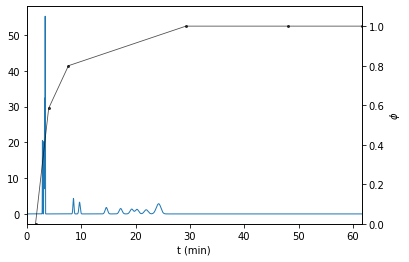

MEASUREMENT MO  18  RES SCORE  8.01779045919965 TIME SCORE 10.150385890978136


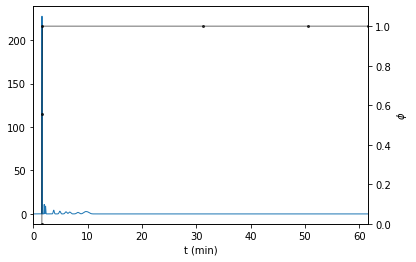

MEASUREMENT MO  19  RES SCORE  12.326507830045491 TIME SCORE 28.62220519707796


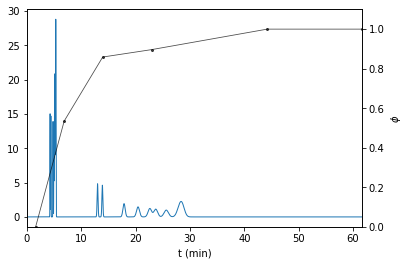

MEASUREMENT MO  20  RES SCORE  12.849382778203406 TIME SCORE 38.419291783173676


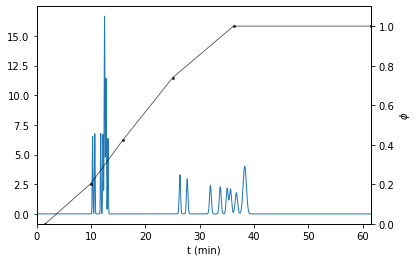

MEASUREMENT MO  21  RES SCORE  8.0063137267211 TIME SCORE 10.151142248644723


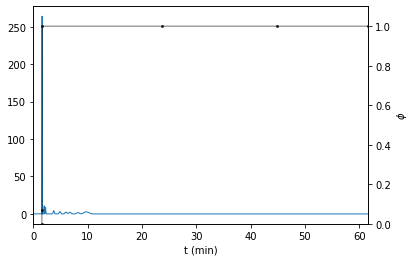

MEASUREMENT MO  22  RES SCORE  8.07252426201328 TIME SCORE 16.47751848682571


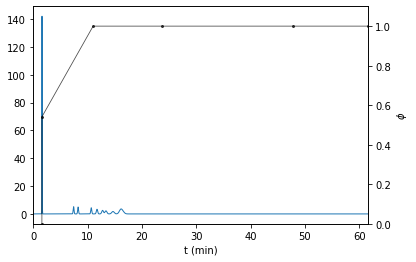

MEASUREMENT MO  23  RES SCORE  12.165416921842755 TIME SCORE 15.13541051531923


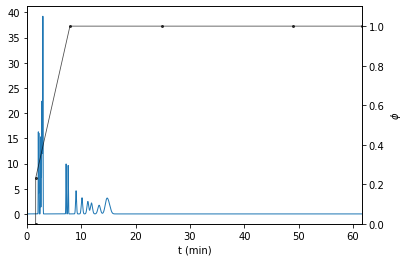

MEASUREMENT MO  24  RES SCORE  11.452689194353415 TIME SCORE 13.267432586324762


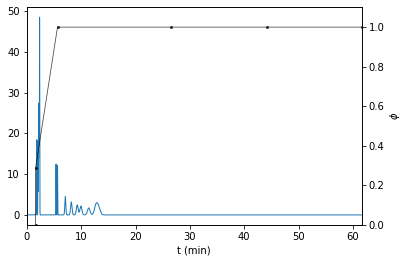

In [13]:
# create some lists to store results in
scores_mo_all = []
seperate_scores_mo_all = []
pars_mo_all = []

ref_point = torch.tensor([0, -60])

# Loop over trials
for trial in range(trials):
    print('Trial ', trial)
    
    # Set random seed for reproducibility
    seed_everything(trial)
    
    # create lists to fill with results per trial
    scores_mo = []
    pars_mo = []
    
    # generate initial experiments
    pars = generate_initial_sorted_data(bounds, n=init_measurements)
    pars_mo = pars
    # convert to parameters that retention modeling code can handle
    phi_list, t_list = bo_to_rm(pars, fixed_phi_pars, fixed_time_pars)
    
    # Perform random initial experiments
    for i in range(len(phi_list)):
        tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[i], t_list[i], N)
        score = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore = -np.max(tR_list)
        
        score_mo = [score, maxtimescore]

        print('INITIAL MEASUREMENT ', i, ' RES SCORE ', score, 'TIME SCORE', -maxtimescore)
        plot_chromatogram(tR_list, W_list, phi_list[i], t_list[i], t_D, t_0, t_init)

        scores_mo.append(score_mo)
    
    # Now we are ready to do BO loop
    for iteration in range(iterations):
        # perform BO round
        new_pars_mo = MOBO_round(bounds, norm_bounds, np.array(scores_mo), pars_mo, ref_point)

        phi_list_mo, t_list_mo = bo_to_rm(new_pars_mo, fixed_phi_pars, fixed_time_pars)

        # perform experiments
        tR_list_mo, W_list_mo = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_mo[0], 
                                                     t_list_mo[0],N)
        # compute scores
        score_mo = capped_sum_of_resolutions(tR_list_mo, W_list_mo, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore_mo = -np.max(tR_list_mo)


        print('MEASUREMENT MO ', iteration, ' RES SCORE ', score_mo, 'TIME SCORE', -maxtimescore_mo)
        plot_chromatogram(tR_list_mo, W_list_mo, phi_list_mo[0], t_list_mo[0], t_D, t_0, t_init)

        score_mo = [score_mo, maxtimescore_mo]

        # update training data
        # update scores
        scores_mo.append(score_mo)

        # update pars
        pars_mo = np.concatenate((pars_mo, new_pars_mo), axis=0)
    
    # after each trial, append all values to list
    scores_mo_all.append(scores_mo)
    pars_mo_all.append(pars_mo)

## Visualize results

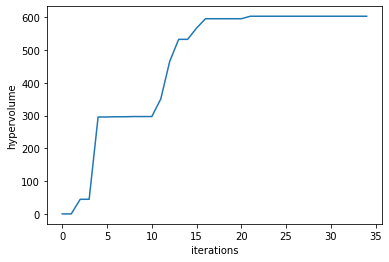

In [14]:
trial_to_observe = 0

# Visualize hypervolume
hvs = hv(np.array(scores_mo_all), ref_point)
plt.plot(hvs[trial_to_observe])
plt.xlabel('iterations')
plt.ylabel('hypervolume')
plt.show()

<IPython.core.display.Javascript object>


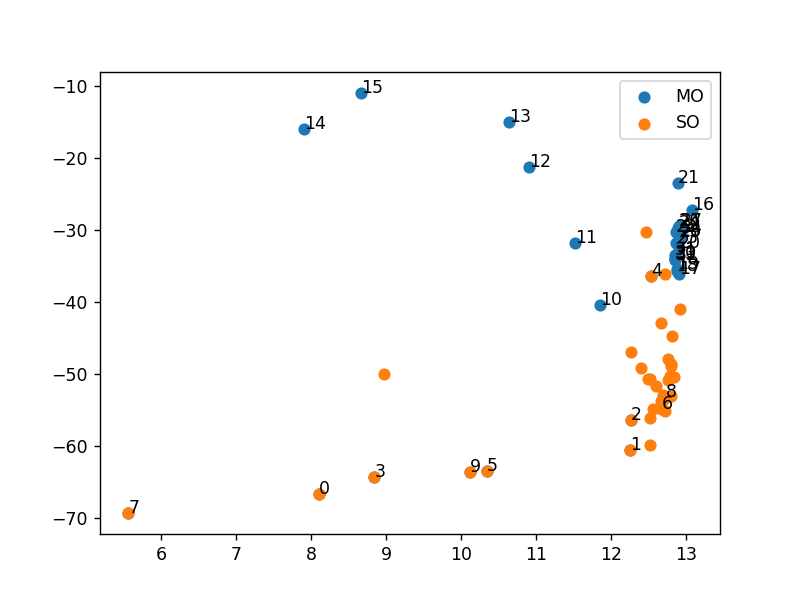

In [15]:
%matplotlib notebook

# Visualize Pareto front
plt.scatter(np.array(scores_mo_all[trial_to_observe])[:,0], np.array(scores_mo_all[trial_to_observe])[:,1], label='MO')

# plot indices
counter = 0
for y in zip(np.array(scores_mo_all[trial_to_observe])[:,0], np.array(scores_mo_all[trial_to_observe])[:,1]):
    plt.text(y[0], y[1], str(counter))
    counter += 1

# plot the single-objective run for comparison
plt.scatter(np.array(seperate_scores_so_all[trial_to_observe])[:,0], 
            np.array(seperate_scores_so_all[trial_to_observe])[:,1], label='SO')
plt.legend()
plt.show()

Measurement  16


<IPython.core.display.Javascript object>


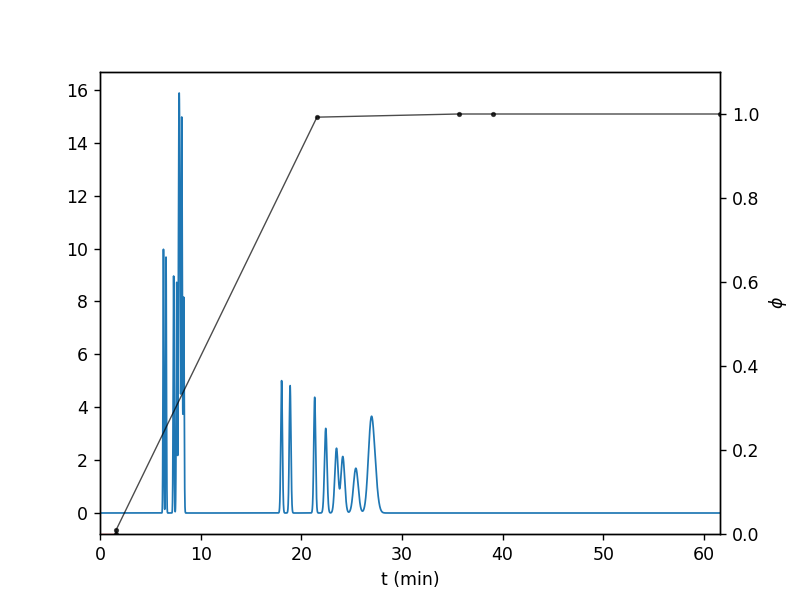

In [16]:
# plot a measurement on the Pareto front (see the numbers in the plot above)
idxloc = 16
best_pars = np.reshape(np.array(pars_mo_all)[trial_to_observe, idxloc], (1,-1))

phi_list, t_list = bo_to_rm(best_pars, fixed_phi_pars, fixed_time_pars)

# perform experiments
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[0], 
                                             t_list[0],N)
print('Measurement ', idxloc)
plot_chromatogram(tR_list, W_list, phi_list[0], t_list[0], t_D, t_0, t_init)

Measurement  8


<IPython.core.display.Javascript object>


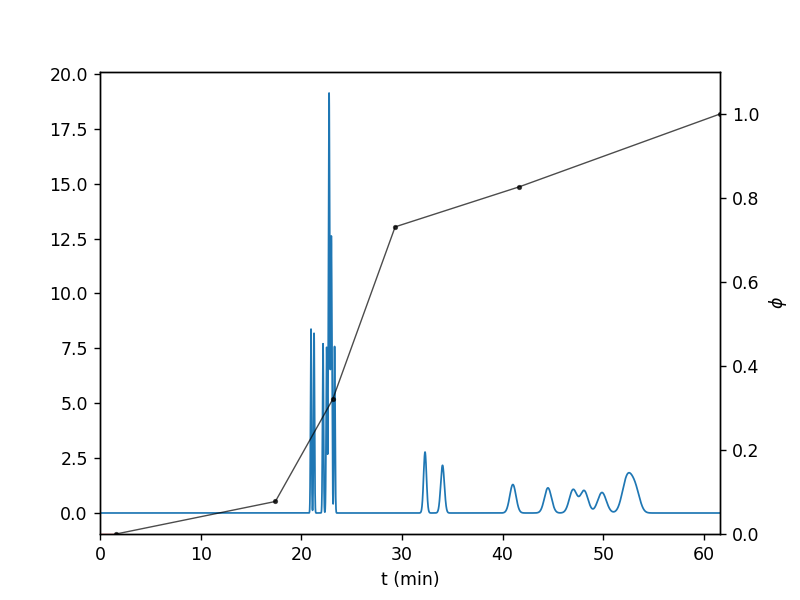

In [17]:
# for SO experiments
idxloc = 8
best_pars = np.reshape(np.array(pars_so_all)[trial_to_observe, idxloc], (1,-1))

phi_list, t_list = bo_to_rm(best_pars, fixed_phi_pars, fixed_time_pars)

# perform experiments
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[0], 
                                             t_list[0],N)
print('Measurement ', idxloc)
plot_chromatogram(tR_list, W_list, phi_list[0], t_list[0], t_D, t_0, t_init)